# Chest X-ray Images

In [3]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [11]:
# Load and Prepare the Dataset

zip_path = 'Disease Detection.zip'
extraction_path = 'Disease_Detection'

# Unzip the dataset
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extraction_path)

# Function to load and preprocess images
def load_images_from_folder(folder, img_size=(128, 128)):
    images, labels = [], []
    for category in os.listdir(folder):
        category_path = os.path.join(folder, category)
        if os.path.isdir(category_path):
            for label in os.listdir(category_path):
                label_folder = os.path.join(category_path, label)
                if os.path.isdir(label_folder):
                    for filename in os.listdir(label_folder):
                        img_path = os.path.join(label_folder, filename)
                        try:
                            img = Image.open(img_path).convert('RGB')  # Convert to RGB
                            img = img.resize(img_size)  # Resize the image
                            images.append(np.array(img))
                            labels.append(label)  # Append the label
                        except Exception as e:
                            print(f"Error loading image {img_path}: {e}")
    return np.array(images), np.array(labels)

# Load images
images, labels = load_images_from_folder(extraction_path)

# Normalize pixel values
images = images.astype('float32') / 255.0

# One-hot encode the labels (ensure two columns for two classes)
lb = LabelBinarizer()
labels_encoded = lb.fit_transform(labels)

# Check if the encoding needs adjustment (e.g., in case of binary classification)
if labels_encoded.shape[1] == 1:  # If only one column, convert to two columns
    labels_encoded = np.hstack((1 - labels_encoded, labels_encoded))  # Invert binary labels to get two columns

# Now you can proceed to split the data and train the model
X_train, X_temp, y_train, y_temp = train_test_split(images, labels_encoded, test_size=0.30, random_state=42, stratify=labels_encoded)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

In [12]:
# Define the Data Augmentation Generator

train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the generator on the training data
train_datagen.fit(X_train)

# Build the CNN Model

model = Sequential()

# Input layer
model.add(Input(shape=(128, 128, 3)))

# Convolutional Layers
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the layers
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Regularization

# Output Layer (Assuming 2 classes: 'normal' and 'opacity')
model.add(Dense(2, activation='softmax'))  # Multi-class classification

In [13]:
# Compile the Model

model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Confirm the model structure
model.summary()

# Train the Model

batch_size = 16  # Adjust batch size for your system's memory
# Now train the model with properly encoded labels
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_val, y_val),
    epochs=50,
    steps_per_epoch=len(X_train) // batch_size,
    validation_steps=len(X_val) // batch_size
)

# Optionally, save the model after training
model.save('pneumonia_detection_model.h5')

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,898 (12.61 MB)

 Trainable params: 3,304,898 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


C:\Users\milto\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


256/256 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.7171 - loss: 0.6028 - val_accuracy: 0.7301 - val_loss: 0.5192
Epoch 2/50
  1/256 ━━━━━━━━━━━━━━━━━━━━ 19s 77ms/step - accuracy: 0.7500 - loss: 0.4716

C:\Users\milto\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7500 - loss: 0.4716 - val_accuracy: 0.7301 - val_loss: 0.5170
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.7446 - loss: 0.5122 - val_accuracy: 0.8485 - val_loss: 0.3341
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7500 - loss: 0.4398 - val_accuracy: 0.7813 - val_loss: 0.4186
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 79ms/step - accuracy: 0.8026 - loss: 0.4238 - val_accuracy: 0.7813 - val_loss: 0.4070
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6875 - loss: 0.4990 - val_accuracy: 0.7916 - val_loss: 0.3952
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 94ms/step - accuracy: 0.8299 - loss: 0.3799 - val_accuracy: 0.8588 - val_loss: 0.3310
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9375 - loss: 0.1901 - val_accuracy: 0.8554 - val_loss: 0.3281
Epoch 9/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 24s 93ms/step - accuracy: 0.8445 - loss: 0.3370 - val_accuracy: 0.870

28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
Classification Report:
              precision    recall  f1-score   support

      normal       0.90      0.87      0.89       238
     opacity       0.95      0.96      0.96       641

    accuracy                           0.94       879
   macro avg       0.93      0.92      0.92       879
weighted avg       0.94      0.94      0.94       879



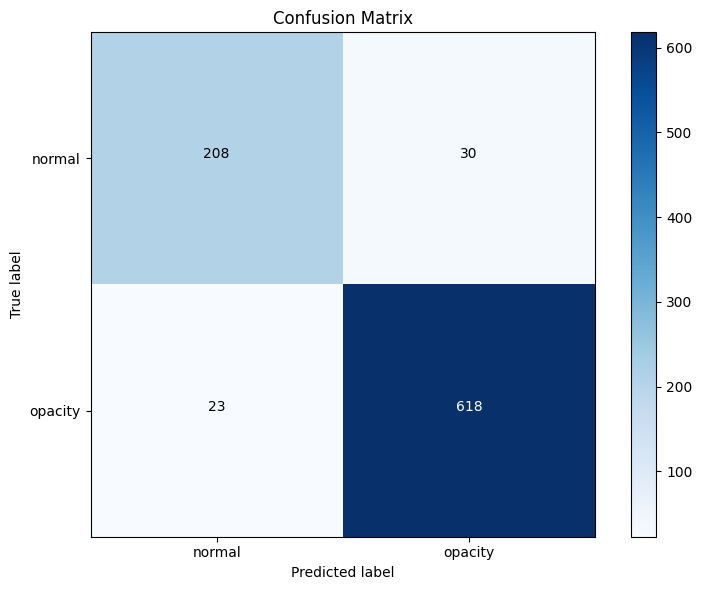

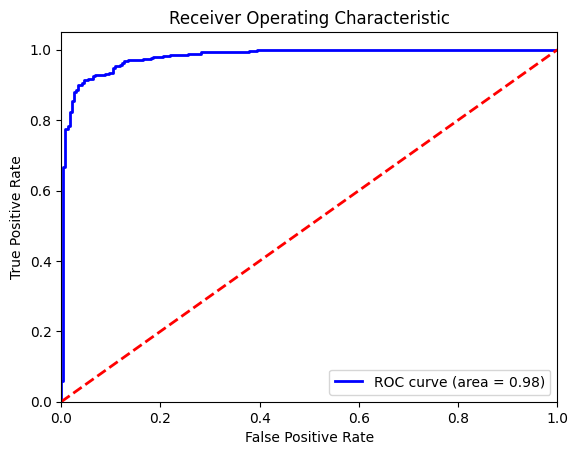

In [14]:
# Evaluate Model Performance

# Predictions on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=lb.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(lb.classes_))
plt.xticks(tick_marks, lb.classes_)
plt.yticks(tick_marks, lb.classes_)

# Display Confusion Matrix values
thresh = conf_matrix.max() / 2.
for i, j in np.ndindex(conf_matrix.shape):
    plt.text(j, i, f'{conf_matrix[i, j]}', horizontalalignment="center",
             color="white" if conf_matrix[i, j] > thresh else "black")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])  # Probabilities of the positive class
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [15]:
# Load and Predict on a New Image

def load_and_preprocess_image(image_path, img_size=(128, 128)):
    try:
        img = Image.open(image_path).convert('RGB')  # Ensure the image is in RGB format
        img = img.resize(img_size)  # Resize to match model input
        img = np.array(img).astype('float32') / 255.0  # Normalize pixel values
        return np.expand_dims(img, axis=0)  # Add batch dimension
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Example: Load and Predict
image_path = 'C:\\Users\\milto\\Downloads\\Chest.jpeg'  # Path to your new image
new_image = load_and_preprocess_image(image_path)

if new_image is not None:
    predictions = model.predict(new_image)
    predicted_class = np.argmax(predictions, axis=1)[0]
    label_map = {0: 'normal', 1: 'opacity'}  # Adjust based on your classes
    predicted_label = label_map[predicted_class]
    print(f'Predicted Label for {image_path}: {predicted_label}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
Predicted Label for C:\Users\milto\Downloads\Chest.jpeg: opacity
